Upgrade pip installer to match python version

In [2]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Installing all necessary packages


In [3]:
%pip install sklearn
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install nflfastpy
%pip install statsmodels

%pip install nfl_data_py
%pip install seaborn
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [2]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier

In [3]:
pbp = nfl.import_pbp_data([2022, 2023])

2022 done.
2023 done.
Downcasting floats.


In [5]:
pbp.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,None,None,None,...,,,0.0,0.0,NaN,NaN,NaN,None,None,None
1,43.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036157;00-0035202;00-0037984;00-0029597;00...,00-0035537;00-0032134;00-0034419;00-0036500;00...,11.0,11.0,NaN,NaN,NaN,None,None,None
2,68.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11.0,11.0,NaN,NaN,NaN,None,None,None
3,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0032234;00-0036979;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11.0,11.0,0.56,3.07,1.0,ANGLE,ZONE_COVERAGE,COVER_2
4,115.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11.0,11.0,NaN,NaN,NaN,None,None,None


In [6]:
print(pbp.shape)
pbp_clean = pbp[(pbp['pass'] == 1) & (pbp['play_type'] != "no_play")]
print(pbp_clean.shape)

(99248, 390)
(42907, 390)


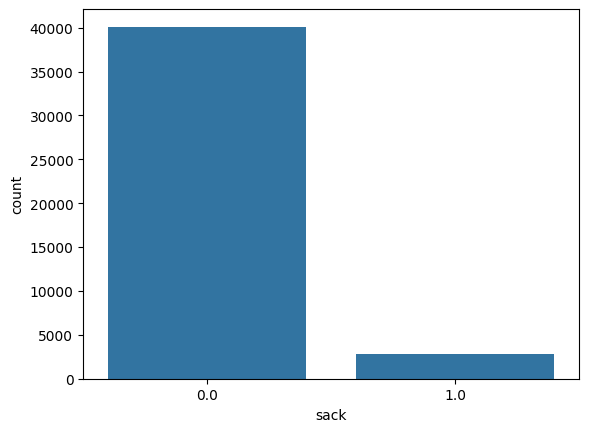

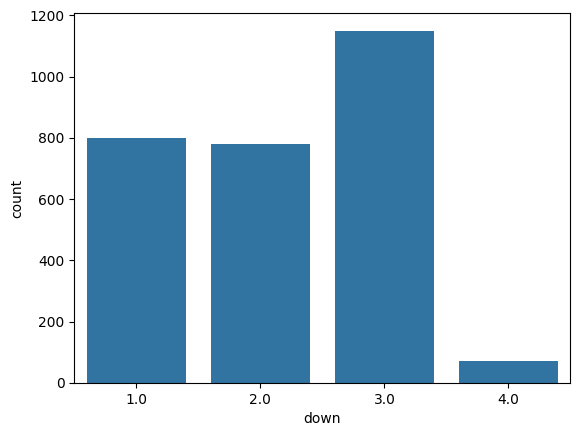

In [7]:
sns.countplot(x=pbp_clean["sack"])
plt.show()
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["down"])
plt.show()

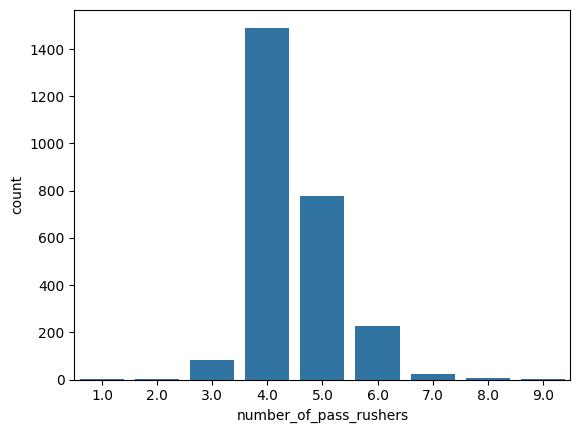

In [12]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["number_of_pass_rushers"])
plt.show()

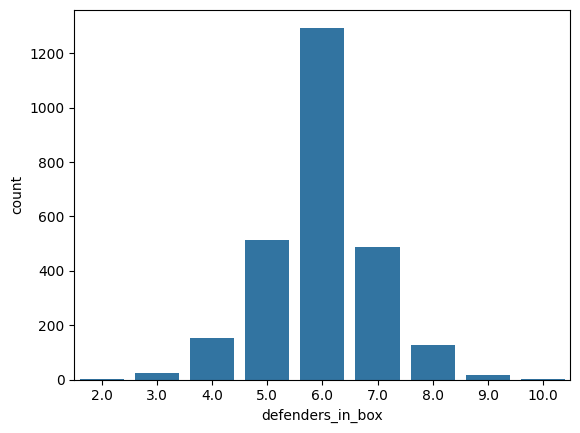

In [13]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["defenders_in_box"])
plt.show()

In [14]:
pbp_clean.loc[:, 'obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)

/var/folders/n6/fctsvhx51zv2t2mnhw79_mxh0000gn/T/ipykernel_13328/1064845038.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp_clean.loc[:, 'obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)
/var/folders/n6/fctsvhx51zv2t2mnhw79_mxh0000gn/T/ipykernel_13328/1064845038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_clean.loc[:, 'obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)


In [15]:
pre_df = pbp_clean[['game_id', 'play_id', 'season', 'name', 'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining',
                    'defenders_in_box', 'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack']]
df = pre_df.dropna()
df.isna().sum()

game_id                   0
play_id                   0
season                    0
name                      0
down                      0
ydstogo                   0
yardline_100              0
game_seconds_remaining    0
defenders_in_box          0
number_of_pass_rushers    0
xpass                     0
obvious_pass              0
sack                      0
dtype: int64

In [16]:
df.head()

,game_id,play_id,season,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack
3,2022_01_BAL_NYJ,89.0,2022,J.Flacco,1.0,10.0,59.0,3569.0,6.0,4.0,0.389904,0,0.0
5,2022_01_BAL_NYJ,136.0,2022,J.Flacco,3.0,5.0,54.0,3541.0,7.0,4.0,0.963242,0,0.0
7,2022_01_BAL_NYJ,202.0,2022,L.Jackson,1.0,10.0,72.0,3522.0,7.0,4.0,0.479318,0,0.0
8,2022_01_BAL_NYJ,230.0,2022,L.Jackson,2.0,6.0,68.0,3501.0,6.0,3.0,0.608057,0,0.0
11,2022_01_BAL_NYJ,301.0,2022,L.Jackson,2.0,10.0,60.0,3379.0,5.0,4.0,0.565180,0,0.0


In [17]:
df.loc[:, 'down'] = df['down'].astype('category')
df_no_ids = df.drop(columns = ['game_id', 'play_id', 'name', 'season'])
df_no_ids = pd.get_dummies(df_no_ids, columns = ['down'])

In [18]:
df_no_ids.columns

Index(['ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
       'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack', 'down_1.0',
       'down_2.0', 'down_3.0', 'down_4.0'],
      dtype='object')

In [19]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(df_no_ids, df_no_ids['sack']):
    strat_train_set = df_no_ids.iloc[train_index]
    strat_test_set = df_no_ids.iloc[test_index]

X_train = strat_train_set.drop(columns = ['sack'])
Y_train = strat_train_set['sack']
X_test = strat_test_set.drop(columns = ['sack'])
Y_test = strat_test_set['sack']

In [20]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, Y_train)

LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, LR_pred))


Brier Score:  0.06085825109000016


In [21]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

RF_pred = pd.DataFrame(RF.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, RF_pred))

Brier Score:  0.0654644052554288


In [22]:
XGB = XGBClassifier(objective="binary:logistic", random_state=42)
XGB.fit(X_train, Y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, XGB_pred))

Brier Score:  0.06294788510932207


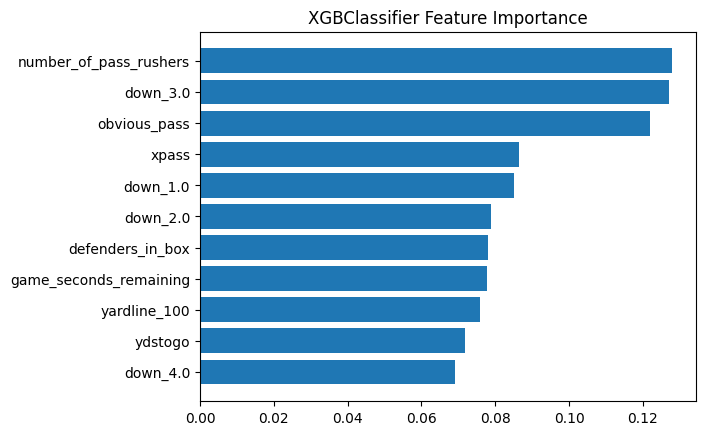

In [23]:
sorted_idx = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.title("XGBClassifier Feature Importance")
plt.show()

In [24]:
data_for_prediction = df_no_ids.drop('sack', axis = 1)

XGB_predictions = pd.DataFrame(XGB.predict_proba(data_for_prediction), columns = ['no_sack_probability', 'sack_probability'])[['sack_probability']]

original_data_with_predictions = df.reset_index().drop(columns = ['index'])
original_data_with_predictions['sack_probability'] = XGB_predictions

original_data_with_predictions['sacks_over_under'] = original_data_with_predictions['sack'] - original_data_with_predictions['sack_probability']

summary_2023 = original_data_with_predictions[(original_data_with_predictions['season'] == 2023)].groupby('name').agg({'sack': 'sum', 'sack_probability': 'sum', 'sacks_over_under': 'sum'}).reset_index().sort_values('sacks_over_under', ascending = True)

print(summary_2023)

             name  sack  sack_probability  sacks_over_under
41        J.Allen  23.0         39.895779        -16.895781
80      P.Mahomes  25.0         38.950562        -13.950562
56         J.Love  28.0         40.253586        -12.253588
98   T.Tagovailoa  27.0         35.146275         -8.146275
72     M.Stafford  28.0         35.428951         -7.428952
..            ...   ...               ...               ...
10        B.Young  51.0         40.117035         10.882966
26        D.Jones  30.0         16.670177         13.329823
101      Z.Wilson  46.0         31.048304         14.951695
91       T.DeVito  36.0         19.007221         16.992779
86       S.Howell  59.0         41.770485         17.229515

[102 rows x 4 columns]


In [25]:
summary_2023 = original_data_with_predictions[(original_data_with_predictions['season'] == 2023)].groupby('name').agg({'sack': 'sum', 'sack_probability': 'sum', 'sacks_over_under': 'sum'}).reset_index().sort_values('sack_probability', ascending = False)

print(summary_2023)

            name  sack  sack_probability  sacks_over_under
30    D.Prescott  39.0         42.117580         -3.117582
86      S.Howell  59.0         41.770485         17.229515
53       J.Hurts  37.0         40.571598         -3.571597
56        J.Love  28.0         40.253586        -12.253588
10       B.Young  51.0         40.117035         10.882966
..           ...   ...               ...               ...
89        T.Boyd   0.0          0.015729         -0.015729
33  D.Singletary   0.0          0.014300         -0.014300
59       J.Smith   0.0          0.008654         -0.008654
76        N.Dell   1.0          0.007544          0.992455
55   J.Jefferson   0.0          0.005474         -0.005474

[102 rows x 4 columns]


In [26]:
summary_2023 = original_data_with_predictions[(original_data_with_predictions['season'] == 2023)].groupby('name').agg({'sack': 'sum', 'sack_probability': 'sum', 'sacks_over_under': 'sum'}).reset_index().sort_values('sack_probability', ascending = False)

summary_2023 = summary_2023.head(20)

print(summary_2023)

             name  sack  sack_probability  sacks_over_under
30     D.Prescott  39.0         42.117580         -3.117582
86       S.Howell  59.0         41.770485         17.229515
53        J.Hurts  37.0         40.571598         -3.571597
56         J.Love  28.0         40.253586        -12.253588
10        B.Young  51.0         40.117035         10.882966
7      B.Mayfield  41.0         40.062706          0.937294
41        J.Allen  23.0         39.895779        -16.895781
80      P.Mahomes  25.0         38.950562        -13.950562
50         J.Goff  33.0         38.830452         -5.830451
83       R.Wilson  45.0         36.688526          8.311473
18       C.Stroud  35.0         36.117710         -1.117709
72     M.Stafford  28.0         35.428951         -7.428952
67      L.Jackson  39.0         35.194141          3.805857
98   T.Tagovailoa  27.0         35.146275         -8.146275
23         D.Carr  28.0         33.942570         -5.942570
96     T.Lawrence  32.0         33.79166

In [27]:
summary_2023 = original_data_with_predictions[(original_data_with_predictions['season'] == 2022)].groupby('name').agg({'sack': 'sum', 'sack_probability': 'sum', 'sacks_over_under': 'sum'}).reset_index().sort_values('sack_probability', ascending = False)

summary_2023 = summary_2023.head(20)

print(summary_2023)

           name  sack  sack_probability  sacks_over_under
52    J.Herbert  41.0         49.953438         -8.953437
94      T.Brady  24.0         47.978794        -23.978794
62    K.Cousins  46.0         46.435539         -0.435540
39      G.Smith  49.0         45.187531          3.812469
43     J.Burrow  51.0         45.023800          5.976198
83    P.Mahomes  29.0         44.253174        -15.253174
100  T.Lawrence  31.0         42.843300        -11.843299
41      J.Allen  41.0         41.273182         -0.273183
32      D.Jones  52.0         41.259624         10.740376
53      J.Hurts  42.0         40.760654          1.239345
51       J.Goff  23.0         40.596516        -17.596516
87     R.Wilson  55.0         38.025661         16.974339
33      D.Mills  31.0         37.341450         -6.341450
28       D.Carr  27.0         36.943470         -9.943471
3     A.Rodgers  32.0         35.873936         -3.873934
72       M.Ryan  38.0         34.113144          3.886854
70      M.Jone